In [3]:
import pandas as pd
import pdb
from pathlib import Path
from fastai.vision import *
from fastai.vision.gan import *

In [4]:
simDataX = np.linspace(0,2*np.pi,100)
amp,phase = np.random.rand(10000,1), np.random.rand(10000,1) * np.pi
simDataY = amp * np.sin(phase * simDataX.reshape(1,-1))

In [5]:
yT = torch.tensor(simDataY,dtype=torch.float).unsqueeze(-1)
phaseT = torch.tensor(phase,dtype=torch.float).squeeze(1)

trainDS = torch.utils.data.TensorDataset(yT[:8000],yT[:8000].squeeze(-1))
valDS = torch.utils.data.TensorDataset(yT[8000:],yT[8000:].squeeze(-1))
trainDS.items = [1,2,3]
valDS.items = [1,2,3]
data = DataBunch.create(trainDS,valDS,num_workers=0)

In [143]:
class SineEnc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.LSTM(1,350,batch_first=True)
        self.hiddenAttn = torch.nn.Linear(350,100,bias=False)
        self.lastAttn = torch.nn.Linear(350,100)
        self.attn = torch.nn.Linear(100,1,bias=False)
        self.out = torch.nn.Linear(350,10)
        
    def forward(self,ts):
        output, (h,c) = self.rnn(ts)
        lastWeight = self.lastAttn(output[:,-1])
        hiddenWeight = self.hiddenAttn(output)
        u = torch.tanh(hiddenWeight + lastWeight.unsqueeze(1))
        a = torch.softmax(self.attn(u),0)
        output = (a*output).sum(dim=1)
        return self.out(output)

In [144]:
e = SineEnc().cuda()
e(x).shape

torch.Size([64, 10])

In [131]:
class SineEnc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(100,200)
        self.out = torch.nn.Linear(200,10)
        
    def forward(self,ts):
        h = torch.relu(self.hidden(ts.squeeze(-1)))
        return self.out(h)

In [145]:
class SineDec(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.LSTM(10,350,batch_first=True)
        self.out = torch.nn.Linear(350,1)
        
    def forward(self,ls):
        ls = ls.unsqueeze(1).expand(-1,100,-1)
        output, h = self.rnn(ls)
        return self.out(output).squeeze(-1)

In [146]:
class VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = SineEnc()
        self.dec = SineDec()
        
    def forward(self,ts):
        ls = self.enc(ts)
        out = self.dec(ls)
        return out

In [147]:
model = VAE()
learn = Learner(data,model,loss_func=torch.nn.functional.mse_loss)

In [148]:
x,y = next(iter(data.train_dl))
learn.model(x).shape

torch.Size([64, 100])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


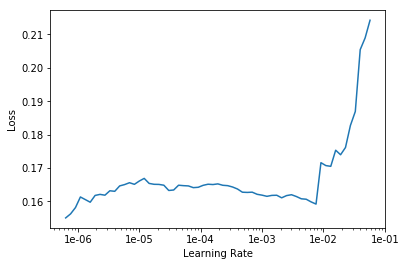

In [149]:
learn.lr_find()
learn.recorder.plot()

In [153]:
learn.fit(10,1e-2)

epoch,train_loss,valid_loss
1,0.150348,0.146674
2,0.150806,0.146740
3,0.152066,0.146859
4,0.151758,0.146665
5,0.151055,0.146815
6,0.152329,0.146679
7,0.153284,0.146965
8,0.151464,0.146635
9,0.150904,0.146646
10,0.150785,0.146780


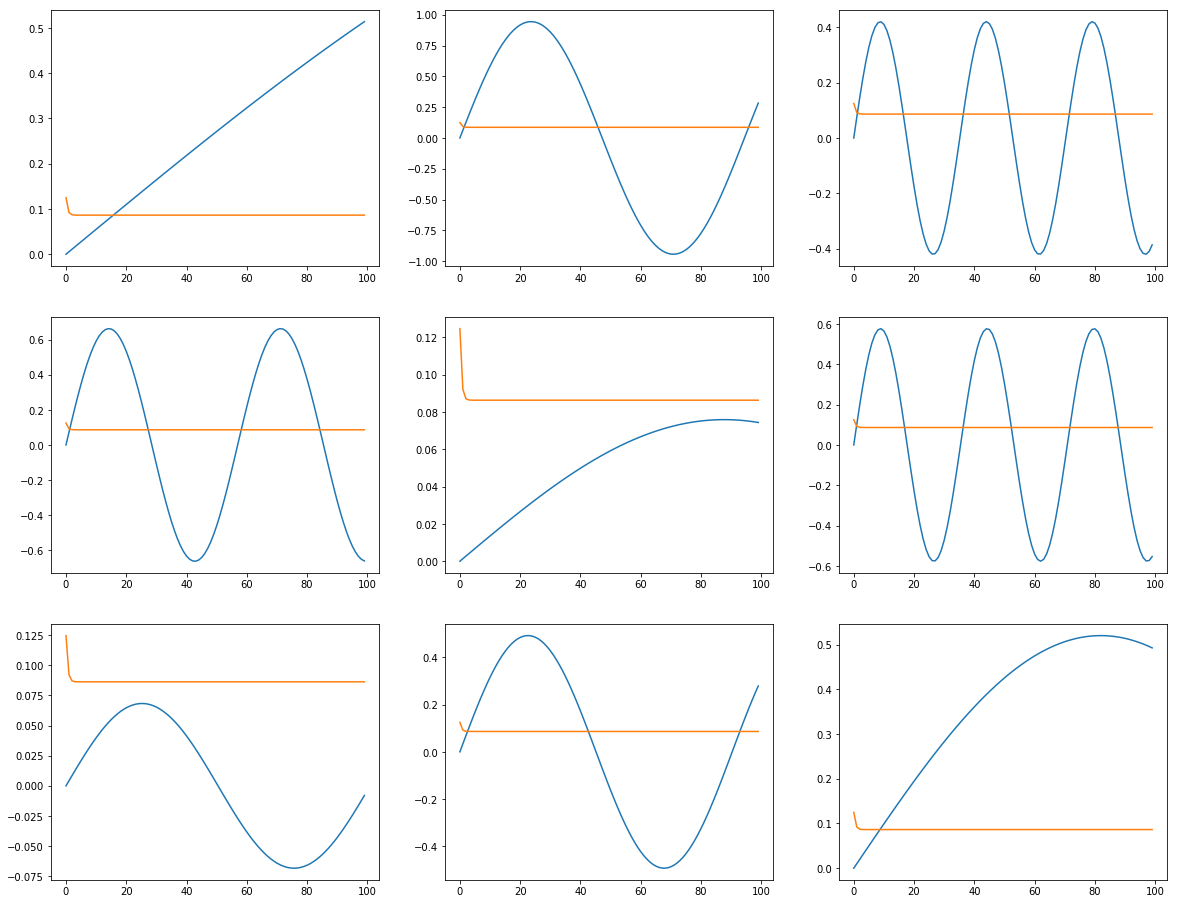

In [151]:
learn.model.eval()
out = learn.model(x)
_,axes = plt.subplots(3,3,figsize=(20,16))

for o,r,ax in zip(x,out,axes.flatten()):
    ax.plot(o.flatten())
    ax.plot(r)